Let's build a simple neural network to classify images from the FashionMNIST dataset.

**1. Import Libraries**

In [54]:
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Reproducibility
torch.manual_seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


*Checking for GPU Availability*

This code checks if a CUDA-enabled GPU is available and sets the `device` accordingly. If no GPU is available, it defaults to the CPU.

**2. Data Preparation**

In [ ]:
# === Příprava dat ===
# Normalizace na mean/std FashionMNIST zrychlí a stabilizuje učení (měřítko vstupu)
# Lehká augmentace (random crop + horizontální flip s malou pravděpodobností) zlepší generalizaci
# DataLoadery: více workerů + pin_memory pro rychlejší přesun batchů do GPU

# FashionMNIST mean/std pro normalizaci
FM_MEAN, FM_STD = (0.2861,), (0.3530,)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Train: lehký crop + občasný flip, Test: jen normalizace
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(FM_MEAN, FM_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FM_MEAN, FM_STD),
])

# Datasety
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_set  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

# Rychlejší DataLoadery (více workerů, pin_memory)
num_workers = max(2, os.cpu_count() // 2)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=256, shuffle=True,
    num_workers=num_workers, pin_memory=True, persistent_workers=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=512, shuffle=False,
    num_workers=num_workers, pin_memory=True, persistent_workers=True
)

**3. Neural Network Model**

In [ ]:
# === Definice modelu (jednoduché MLP) ===
# BatchNorm1d stabilizuje rozložení aktivací (rychlejší konvergence, méně přeučení)
# Dropout vyřazuje část neuronů během tréninku (regularizace)
# Pozn.: Pro obrázky zpravidla lépe funguje malá CNN, ale tady držíme MLP a ladíme jeho generalizaci

class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.30)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.30)
        self.fc3 = nn.Linear(256, 10)

    # Flatten: 1x28x28 -> 784 prvků
    # ReLU: nelinearita
    # BN + Dropout: stabilita a regularizace
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        return self.fc3(x)

model = DenseNet().to(device)
model

DenseNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

**4. Loss & Optimizer**

In [ ]:
# === Ztrátová funkce a optimalizace ===
# CrossEntropyLoss s label_smoothing=0.1 snižuje přísnost na správnou třídu -> lepší robustnost
# AdamW: bezmomentové adaptivní učení + weight decay implementovaný korektně (lepší regularizace)
# OneCycleLR: dynamický plán learning rate v rámci jedné "cyklické" fáze -> rychlá a stabilní konvergence

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-3)

# OneCycleLR – výborný na rychlou a stabilní konvergenci
epochs = 100
# steps_per_epoch = počet batchů na epochu, OneCycleLR očekává krok po KAŽDÉM batchi
# epochs = celkový plán tréninku; při větším počtu epoch se LR ke konci prudce sníží (annealing)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-3,
    steps_per_epoch=len(train_loader), epochs=epochs
)

**5. Training loop**

In [ ]:
# === Trénink ===
# AMP (mixed precision) na GPU zrychlí výpočty a šetří paměť (GradScaler + autocast)
# scheduler.step() voláme po každém batchi (OneCycleLR)
# running_loss a průběžná tréninková přesnost pro monitoring učení

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

history = {'loss': [], 'acc': [], 'lrs': []}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        # optional: torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        # zaznamenat aktuální learning rate z OneCycle
        history['lrs'].append(scheduler.get_last_lr()[0])

        running_loss += loss.item()
        with torch.no_grad():
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    train_acc = 100.0 * correct / total
    epoch_loss = running_loss / len(train_loader)
    history['loss'].append(epoch_loss)
    history['acc'].append(train_acc)

    print(f'Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Train Acc: {train_acc:.2f}%')

/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_14213/843352197.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_14213/843352197.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Epoch [1/100]  Loss: 1.2699  Train Acc: 66.65%
Epoch [2/100]  Loss: 1.0416  Train Acc: 76.13%
Epoch [3/100]  Loss: 0.9938  Train Acc: 78.32%
Epoch [4/100]  Loss: 0.9632  Train Acc: 79.88%
Epoch [5/100]  Loss: 0.9456  Train Acc: 80.71%
Epoch [6/100]  Loss: 0.9323  Train Acc: 81.20%
Epoch [7/100]  Loss: 0.9181  Train Acc: 82.03%
Epoch [8/100]  Loss: 0.9093  Train Acc: 82.34%
Epoch [9/100]  Loss: 0.9051  Train Acc: 82.50%
Epoch [10/100]  Loss: 0.8962  Train Acc: 82.83%
Epoch [11/100]  Loss: 0.8922  Train Acc: 82.92%
Epoch [12/100]  Loss: 0.8860  Train Acc: 83.36%
Epoch [13/100]  Loss: 0.8803  Train Acc: 83.64%
Epoch [14/100]  Loss: 0.8751  Train Acc: 83.82%
Epoch [15/100]  Loss: 0.8687  Train Acc: 84.05%
Epoch [16/100]  Loss: 0.8683  Train Acc: 84.01%
Epoch [17/100]  Loss: 0.8584  Train Acc: 84.52%
Epoch [18/100]  Loss: 0.8577  Train Acc: 84.53%
Epoch [19/100]  Loss: 0.8569  Train Acc: 84.51%
Epoch [20/100]  Loss: 0.8524  Train Acc: 84.77%
Epoch [21/100]  Loss: 0.8487  Train Acc: 84.98%
E

**6. Evaluation on the test set**

In [ ]:
# === Vyhodnocení na testu ===
# torch.no_grad(): vypneme autograd (rychlejší inference, nižší paměť)
# Výpočet celkové přesnosti na testovací sadě

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

test_acc = 100.0 * correct / total
print(f'Accuracy: {test_acc:.2f}%')

/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_14213/3372711990.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Accuracy: 90.33%


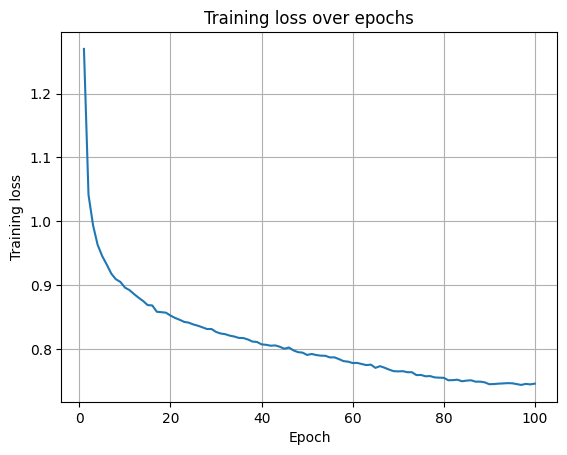

In [60]:
plt.figure()
plt.plot(range(1, epochs+1), history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.grid(True)
plt.show()

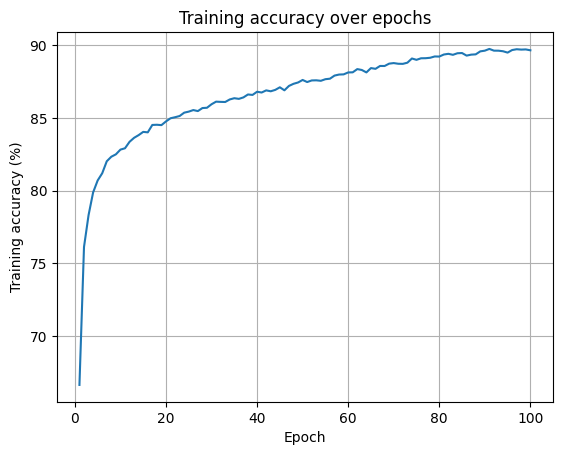

In [61]:
plt.figure()
plt.plot(range(1, epochs+1), history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Training accuracy (%)')
plt.title('Training accuracy over epochs')
plt.grid(True)
plt.show()

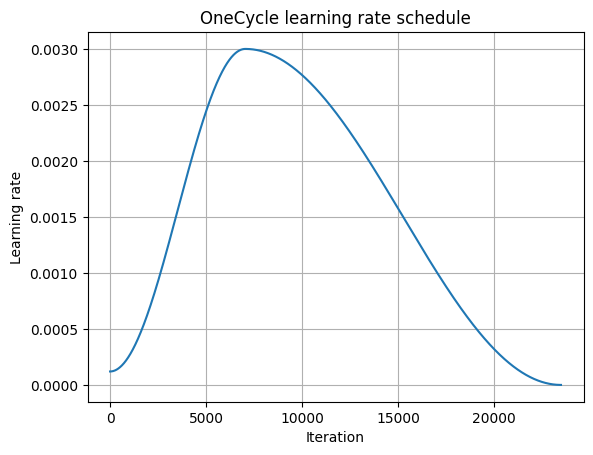

In [62]:
plt.figure()
plt.plot(range(1, len(history['lrs'])+1), history['lrs'])
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.title('OneCycle learning rate schedule')
plt.grid(True)
plt.show()

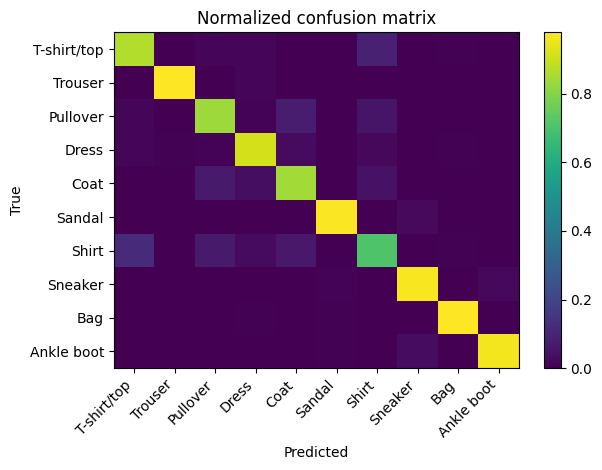

In [63]:
# výpočet confusion matrix bez závislosti na sklearn
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=np.int64)
for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1

# normalizace po řádcích (po „true“ třídách)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm_norm, aspect='auto')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.yticks(range(num_classes), class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

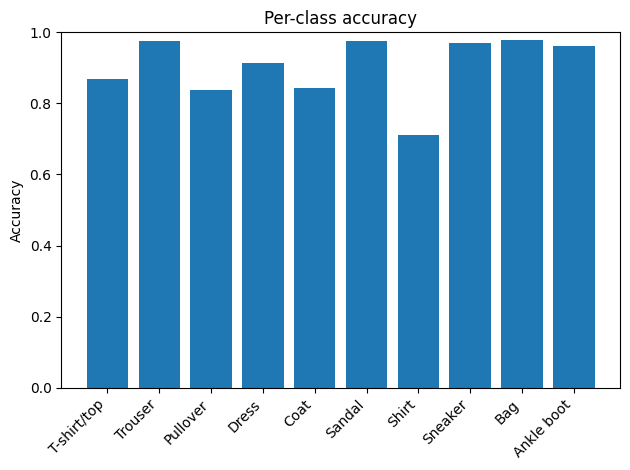

In [64]:
per_class_acc = (cm.diagonal() / cm.sum(axis=1)).tolist()

plt.figure()
plt.bar(range(num_classes), per_class_acc)
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy')
plt.title('Per-class accuracy')
plt.tight_layout()
plt.show()

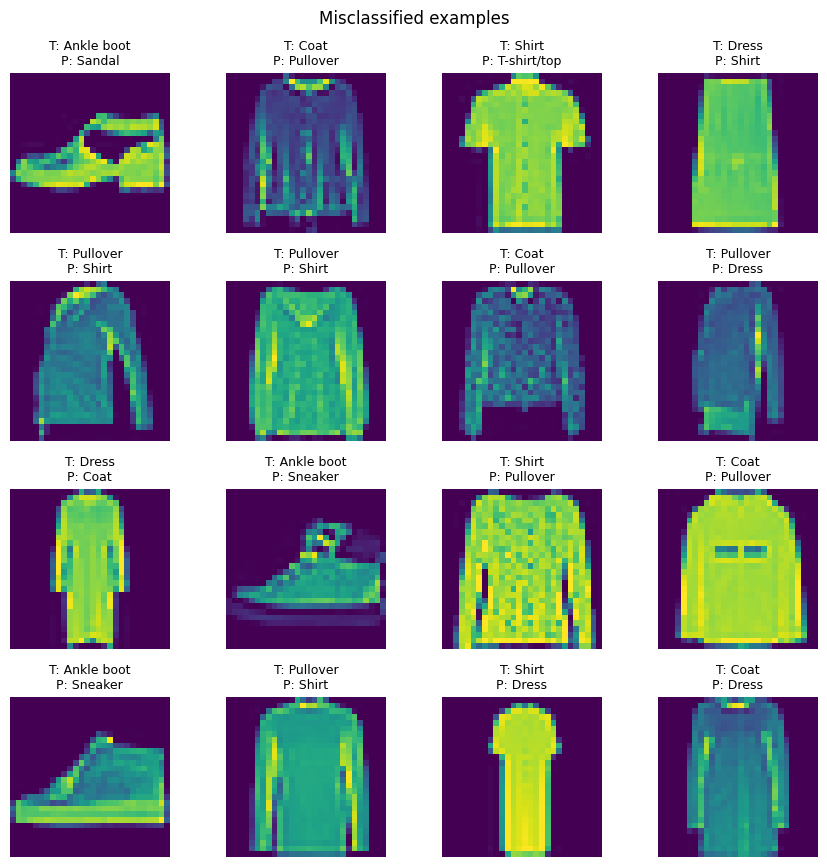

In [ ]:
# nasbíráme pár chyb – z test_loaderu znovu, abychom měli obrázky pro vykreslení
mis_images = []
mis_true = []
mis_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        mismatch = preds != labels
        if mismatch.any():
            imgs = images[mismatch].cpu()
            trues = labels[mismatch].cpu()
            preds_ = preds[mismatch].cpu()
            mis_images.append(imgs)
            mis_true.append(trues)
            mis_pred.append(preds_)
        if sum(x.size(0) for x in mis_images) >= 16:  # stačí 16 kusů
            break

if mis_images:
    mis_images = torch.cat(mis_images)[:16]
    mis_true = torch.cat(mis_true)[:16]
    mis_pred = torch.cat(mis_pred)[:16]

    # denormalizace pro zobrazení
    mis_images = mis_images * FM_STD[0] + FM_MEAN[0]
    mis_images = mis_images.clamp(0, 1)

    n = mis_images.size(0)
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = mis_images[i].squeeze(0).numpy()
        ax.imshow(img)  # bez explicitního cmap
        t = class_names[int(mis_true[i])]
        p = class_names[int(mis_pred[i])]
        ax.set_title(f'T: {t}\nP: {p}', fontsize=9)
        ax.axis('off')
    plt.suptitle('Misclassified examples', y=0.98)
    plt.tight_layout()
    plt.show()